<a href="https://colab.research.google.com/github/sainirutvi/hello-rutvi/blob/master/ARIMA_MODEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import pandas as pd
# Import Data
data = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'], index_col='date')

In [ ]:
# Compute Seasonal Index
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

# multiplicative seasonal component
result_mul = seasonal_decompose(data['value'][-36:],   # 3 years
                                model='multiplicative', 
                                extrapolate_trend='freq')

seasonal_index = result_mul.seasonal[-12:].to_frame()
seasonal_index['month'] = pd.to_datetime(seasonal_index.index).month

# merge with the base data
data['month'] = data.index.month
df = pd.merge(data, seasonal_index, how='left', on='month')
df.columns = ['value', 'month', 'seasonal_index']
df.index = data.index  # reassign the index.

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
!pip install pmdarima


import pmdarima as pm

# SARIMAX Model
sxmodel = pm.auto_arima(df[['value']], exogenous=df[['seasonal_index']],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=None, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

sxmodel.summary()

     |████████████████████████████████| 1.5MB 2.7MB/s 
Performing stepwise search to minimize aic
Fit ARIMA(1,0,1)x(0,1,1,12) [intercept=True]; AIC=536.818, BIC=556.362, Time=2.626 seconds
Fit ARIMA(0,0,0)x(0,1,0,12) [intercept=True]; AIC=626.061, BIC=635.834, Time=0.056 seconds
Fit ARIMA(1,0,0)x(1,1,0,12) [intercept=True]; AIC=598.068, BIC=614.356, Time=0.817 seconds
Fit ARIMA(0,0,1)x(0,1,1,12) [intercept=True]; AIC=613.475, BIC=629.762, Time=0.634 seconds
Fit ARIMA(0,0,0)x(0,1,0,12) [intercept=False]; AIC=759.274, BIC=765.789, Time=0.136 seconds
Fit ARIMA(1,0,1)x(0,1,0,12) [intercept=True]; AIC=561.407, BIC=577.695, Time=0.441 seconds
Fit ARIMA(1,0,1)x(1,1,1,12) [intercept=True]; AIC=556.537, BIC=579.339, Time=3.750 seconds
Near non-invertible roots for order (1, 0, 1)(1, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(1,0,1)x(0,1,2,12) [intercept=True]; AIC=538.817, BIC=561.620, Time=8.293 seconds
Fit ARIMA(1,0,

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  204
Model:             SARIMAX(3, 0, 1)x(1, 1, 2, 12)   Log Likelihood                -250.092
Date:                            Fri, 08 May 2020   AIC                            520.185
Time:                                    15:42:47   BIC                            552.760
Sample:                                07-01-1991   HQIC                           533.378
                                     - 06-01-2008                                         
Covariance Type:                              opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept          0.0253      0.034      0.752      0.452      -0.041       0.091
seasonal_index  1.093e-05   7.86e+04   1.39e-10      1.000   -1.54e+05    1.54e+05
ar.L1             -0.1229      0.150     -0.820      0.412      -0.417       0.171
ar.L2              0.4830      0.062      7.851      0.000       0.362       0.604
ar.L3              0.5233      0.083      6.315      0.000       0.361       0.686
ma.L1              0.1922      0.165      1.163      0.245      -0.132       0.516
ar.S.L12           0.8401      0.124      6.797      0.000       0.598       1.082
ma.S.L12          -1.6397      0.167     -9.844      0.000      -1.966      -1.313
ma.S.L24           0.8332      0.130      6.417      0.000       0.579       1.088
sigma2             0.6952      0.088      7.908      0.000       0.523       0.867
===================================================================================
Ljung-Box (Q):                       61.12   Jarque-Bera (JB):               103.74
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):              12.73   Skew:                             0.40
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

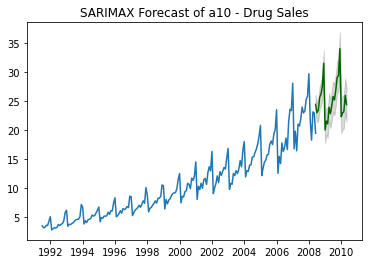

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# Forecast
n_periods = 24
fitted, confint = sxmodel.predict(n_periods=n_periods, 
                                  exogenous=np.tile(seasonal_index.value, 2).reshape(-1,1), 
                                  return_conf_int=True)

index_of_fc = pd.date_range(data.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(data['value'])
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMAX Forecast of a10 - Drug Sales")
plt.show()